In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import statsmodels.formula.api as smf
from scipy import stats

In [2]:
# os.getcwd()
root = f"/Users/{os.getlogin()}/workspace/wage-gap"

In [3]:
df = pd.read_csv(f"{root}/wage2015_subsample_inference.csv", encoding="utf-8")
print(f"Total number of instances in df (unmodified, raw data): {df.shape[0]}")

Total number of instances in df (unmodified, raw data): 5150


In [4]:
df_scl = df.loc[df["scl"] == 1]

In [5]:
df_clg = df.loc[df["clg"] == 1]

In [6]:
sample = pd.concat([df_scl, df_clg])
print(f"Total number of instances in sample (filtered by (scl or clg == 1)): {sample.shape[0]}")

Total number of instances in sample (filtered by (scl or clg == 1)): 3068


Text(0.5, 1.0, 'Distribución de los log(salarios)')

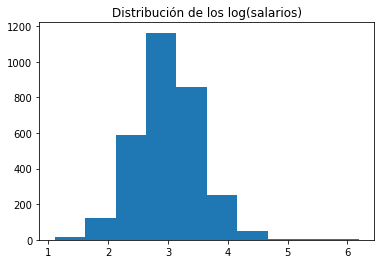

In [7]:
plt.hist(sample["lwage"])
plt.title("Distribución de los log(salarios)")

Text(0.5, 1.0, 'Distribución del log(salario)')

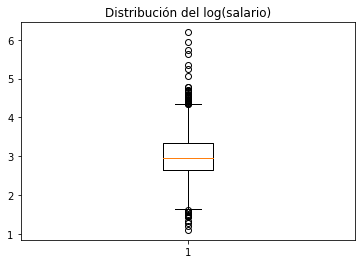

In [8]:
plt.boxplot(sample["lwage"])
plt.title("Distribución del log(salario)")

Text(0.5, 0, 'Experiencia')

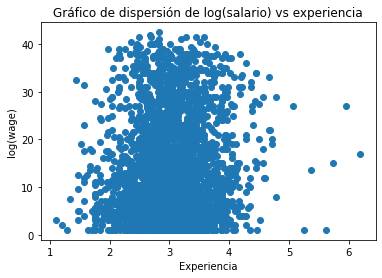

In [9]:
plt.scatter(sample["lwage"], sample["exp1"])
plt.title("Gráfico de dispersión de log(salario) vs experiencia")
plt.ylabel("log(wage)")
plt.xlabel("Experiencia")

In [10]:
formula_basic = "lwage ~ sex + exp1 + shs + hsg + mw + so + we + occ2 + ind2"
formula_flex = "lwage ~ sex + (exp1 + exp2 + exp3 + exp4 + shs + hsg + occ2 + ind2 + mw + so + we) ** 2"

In [11]:
linear_model_basic = smf.ols(formula_basic, data=sample)
linear_model_basic = linear_model_basic.fit()
print(linear_model_basic.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     64.30
Date:                Sun, 17 Jul 2022   Prob (F-statistic):           1.07e-86
Time:                        03:32:23   Log-Likelihood:                -2277.3
No. Observations:                3068   AIC:                             4571.
Df Residuals:                    3060   BIC:                             4619.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4366      0.038     90.407      0.0

In [12]:
linear_model_flex = smf.ols(formula_flex, data=sample)
linear_model_flex = linear_model_flex.fit()
print(linear_model_flex.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     12.73
Date:                Sun, 17 Jul 2022   Prob (F-statistic):           1.59e-75
Time:                        03:32:23   Log-Likelihood:                -2249.3
No. Observations:                3068   AIC:                             4581.
Df Residuals:                    3027   BIC:                             4828.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6148      0.172     21.030      0.0

In [13]:
coef_df = pd.DataFrame({"varname": ["basic_model", "flexible_model"],
                        "coef": [linear_model_basic.params[1], linear_model_flex.params[1]],
                        "error": [linear_model_basic.params[1] - linear_model_basic.conf_int()[0][1],
                                  linear_model_flex.params[1] - linear_model_flex.conf_int()[0][1]]})

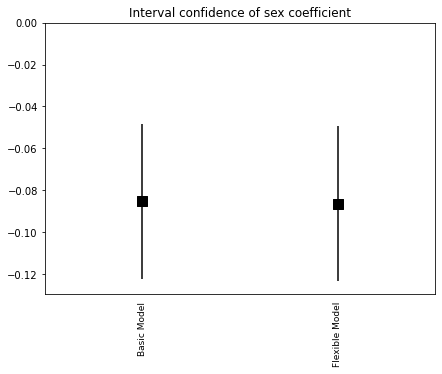

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))
coef_df.plot(x="varname", y="coef", kind="bar",
             ax=ax, color="none", yerr="error", legend=False)
plt.title("Interval confidence of sex coefficient")
ax.set_ylabel("")
ax.set_xlabel("")
ax.scatter(x=np.arange(coef_df.shape[0]), marker="s",
           s=120, y=coef_df["coef"], color="black")
ax.xaxis.set_ticks_position("none")
ax.set_xticklabels(["Basic Model", "Flexible Model"],
                   rotation=90, fontsize=9)
plt.savefig(f"{root}/notebooks/coefplot_py.png")
plt.show()

In [15]:
def poly_regression(df, degree):
    z = np.polyfit(df["exp1"], df["lwage"], degree)
    p = np.poly1d(z)
    output = pd.DataFrame({"x": df["exp1"], "y": p(df["exp1"])})
    output = output.sort_values(by="x", ascending=True)
    return output

In [16]:
reg_line_scl = poly_regression(df_scl, 4)
reg_line_clg = poly_regression(df_clg, 4)

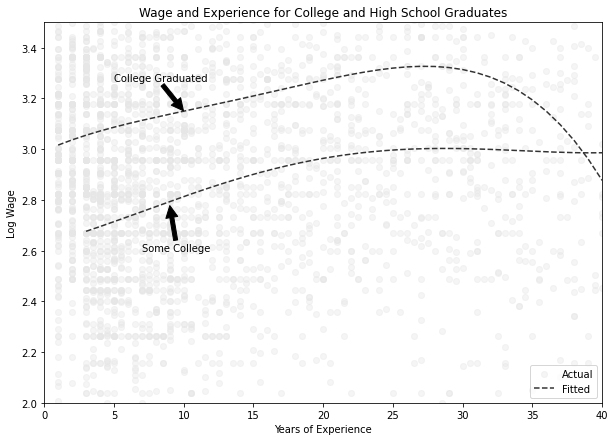

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
ax = plt.gca()
ax.set_ylim([2, 3.5])
ax.set_xlim([0, 40])

plt.scatter(df_scl["exp1"], df_scl["lwage"], color=(0.9, 0.9, 0.9, 0.4), label="Actual")
plt.plot(reg_line_scl["x"], reg_line_scl["y"], "--", color=(0.2, 0.2, 0.2), label="Fitted")
ax.annotate("College Graduated", xy=(10, 3.15), xytext=(5, 3.27), arrowprops=dict(facecolor="black", shrink=0.01))

plt.scatter(df_clg["exp1"], df_clg["lwage"], color=(0.9, 0.9, 0.9, 0.4), label="_nolegend_")
plt.plot(reg_line_clg["x"], reg_line_clg["y"], "--", color=(0.2, 0.2, 0.2), label="_nolegend_")
ax.annotate("Some College", xy=(9, 2.779), xytext=(7, 2.6), arrowprops=dict(facecolor="black", shrink=0.01))

plt.ylabel("Log Wage")
plt.xlabel("Years of Experience")
plt.title("Wage and Experience for College and High School Graduates")
plt.legend()
plt.savefig(f"{root}/notebooks/wageexpforclgandscl_py.png")
plt.show()